In [21]:
import os
import midas_touch2 as mt2
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import warnings
import asyncio
import time
pd.options.display.max_columns = 100000
warnings.filterwarnings('ignore')

if not mt5.initialize():
    print("initialize() failed")
else:
    print("MT5 successfully initialised.\n")

MT5 successfully initialised.



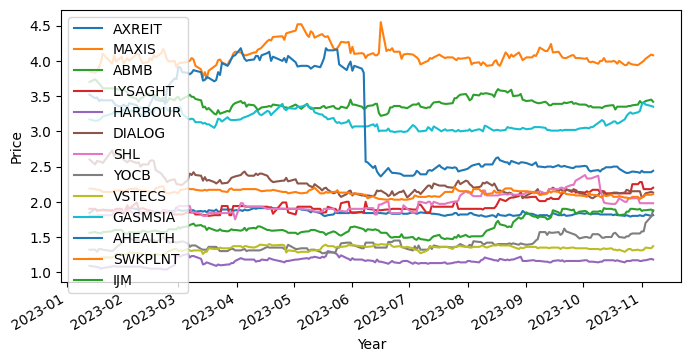

In [22]:
symbols = ['AXREIT', 'MAXIS', 'ABMB', 'LYSAGHT', 'HARBOUR', 
           'DIALOG', 'SHL', 'YOCB', 'VSTECS', 'GASMSIA', 
           'AHEALTH', 'SWKPLNT', 'IJM']

price_df = mt2.download_stocks(symbols)
# def extract_number(col_name):
#     return int(''.join(filter(str.isdigit, col_name)))
# rename_sym = ['5106.KL', '6012.KL', '2488.KL', '9199.KL', '2062.KL', '7277.KL', '6017.KL', '5159.KL', '5162.KL', '5209.KL', '7090.KL', '5135.KL', '3336.KL']
# price_df.columns = rename_sym
# #Sort DataFrame columns using the custom key
# sorted_columns = sorted(price_df.columns, key=extract_number)
# price_df = price_df[sorted_columns]

price_df.plot(figsize=(8,4))
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [23]:
def run_portfolio(prices, commission_rate=0.001):
    # Calculate Alpha1
    alpha1 = -(prices - prices.shift(5)) / prices.shift(5)
    alpha1 = alpha1.dropna() 
    weights = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
    weights[weights < 0] = 0
    weights = weights.div(weights.sum(axis=1), axis=0)
    weights = weights.fillna(0)
    latest_weights = weights.iloc[-1]
    portfolio_returns = (weights.shift() * prices.pct_change()).sum(axis=1)
    portfolio_returns = portfolio_returns - commission_rate
    return weights, latest_weights

weights_df, latest_weights = run_portfolio(price_df)
latest_weights

AXREIT    -0.000000
MAXIS      0.000000
ABMB       0.046207
LYSAGHT    0.556110
HARBOUR    0.000000
DIALOG     0.147434
SHL       -0.000000
YOCB       0.000000
VSTECS     0.000000
GASMSIA    0.000000
AHEALTH    0.000000
SWKPLNT    0.000000
IJM        0.250249
Name: 2023-11-07 00:00:00, dtype: float64

In [24]:
#change allocation units to test

In [38]:
total_investment = 100000 #TRY 15K 10K 5K
previous_allocation_df = mt2.get_folder(folder_name='daily_allocation')
previous_portfolio_df = mt2.get_folder(folder_name='daily_portfolio')
if previous_allocation_df is not None and previous_portfolio_df is not None:
    # Process the existing CSV data
    total_investment = abs(previous_portfolio_df['Total Value'].iloc[-1])
    allocation_df = mt2.calculate_stock_allocation(total_investment, latest_weights, price_df)
    allocation_df['Holding Units'] = previous_allocation_df['Allocated Units']

else: #first run
    allocation_df = mt2.calculate_stock_allocation(total_investment, latest_weights, price_df)
    # Handle the initial run scenario
    print("This is the initial run. No previous allocation data available.")
    allocation_df['Holding Units'] = 0

# Calculate Entry and Exit Units
allocation_df['Entry Units'] = allocation_df.apply(
    lambda row: max(row['Allocated Units'] - row['Holding Units'], 0), axis=1
)
allocation_df['Exit Units'] = allocation_df.apply(
    lambda row: max(row['Holding Units'] - row['Allocated Units'], 0), axis=1
)
numeric_cols = allocation_df.select_dtypes(include=['number']).astype(float)

for col in numeric_cols.columns:
    allocation_df[col] = numeric_cols[col]


#async start here
order_ids = mt2.execute_trades_from_data(allocation_df)
time.sleep(5)
orders_list = [mt2.check_order_status(order_id) for order_id in order_ids]
print(f'orders_list: {orders_list}')
resubmitted_orders = mt2.delete_and_resubmit_orders(orders_list)
print(f'resubmitted_orders: {resubmitted_orders}')
for order in resubmitted_orders:
    symbol = order['symbol']
    price = order['price'] 
    allocation_df.loc[allocation_df['Share Symbol'] == symbol, 'Share Price'] = price
allocation_df
# async def execute_and_monitor(allocation_df, timeout=60):
#     print(allocation_df)
#     order_ids = mt2.execute_trades_from_data(allocation_df)
#     print(f'Waiting for {timeout/60} minutes..')
#     await asyncio.sleep(timeout)
#     orders_list = [mt2.check_order_status(order_id) for order_id in order_ids]  # Renamed from orders_list
#     print(f'orders_list: {orders_list}')
#     resubmitted_orders = mt2.delete_and_resubmit_orders(orders_list)  # Renamed from resubmitted_orders
#     print(f'resubmitted_orders: {resubmitted_orders}')
#     return orders_list, resubmitted_orders  # Return the renamed variables

# # Execute the async function and capture the returned values with the new variable names
# orders_list, resubmitted_orders = asyncio.run(execute_and_monitor(allocation_df, timeout=90))

# Calculate the portfolio value
if previous_allocation_df is not None and previous_portfolio_df is not None: #2nd run onwards
    starting_cash = previous_portfolio_df['Cash Value'].iloc[-1]
    current_share_value = (allocation_df['Allocated Units']*allocation_df['Share Price']).sum()

else: #first run
    starting_cash = total_investment
    current_share_value = (allocation_df['Entry Units']*allocation_df['Share Price']).sum()

portfolio_df = mt2.compile_portfolio_data(allocation_df, starting_cash, current_share_value)

# mt2.save_df_to_csv(portfolio_df, 
#                    folder_name='daily_portfolio', 
#                    file_name='balance',
#                    append=True)
mt2.save_df_to_csv(allocation_df, 
                   folder_name='daily_allocation', 
                   file_name='allocation')


Folder not found: daily_portfolio
This is the initial run. No previous allocation data available.
Placing entry order for ABMB
Order executed successfully, transaction ID = 538172
Placing entry order for LYSAGHT
Order executed successfully, transaction ID = 538173
Placing entry order for DIALOG
Order executed successfully, transaction ID = 538174
Placing entry order for IJM
Order executed successfully, transaction ID = 538175
orders_list: [{'ticket': 538172, 'type': 2, 'volume_initial': 1300.0, 'volume_current': 1300.0, 'price_open': 3.42, 'price_current': 3.4, 'symbol': 'ABMB'}, {'ticket': 538173, 'type': 2, 'volume_initial': 25200.0, 'volume_current': 25200.0, 'price_open': 2.2, 'price_current': 2.18, 'symbol': 'LYSAGHT'}, {'ticket': 538174, 'type': 2, 'volume_initial': 6900.0, 'volume_current': 6900.0, 'price_open': 2.13, 'price_current': 2.13, 'symbol': 'DIALOG'}, {'ticket': 538175, 'type': 2, 'volume_initial': 13300.0, 'volume_current': 13300.0, 'price_open': 1.87, 'price_current'

In [37]:
allocation_df

,Share Symbol,Share Price,Allocated Units,Weights
0,AXREIT,1.81,0,-0.000000
1,MAXIS,4.08,0,0.000000
2,ABMB,3.42,1300,0.046207
3,LYSAGHT,2.20,25200,0.556110
4,HARBOUR,1.18,0,0.000000
5,DIALOG,2.13,6900,0.147434
6,SHL,1.98,0,-0.000000
7,YOCB,1.88,0,0.000000
8,VSTECS,1.37,0,0.000000
9,GASMSIA,3.35,0,0.000000


In [27]:
total_investment

100000

In [28]:
latest_weights

AXREIT    -0.000000
MAXIS      0.000000
ABMB       0.046207
LYSAGHT    0.556110
HARBOUR    0.000000
DIALOG     0.147434
SHL       -0.000000
YOCB       0.000000
VSTECS     0.000000
GASMSIA    0.000000
AHEALTH    0.000000
SWKPLNT    0.000000
IJM        0.250249
Name: 2023-11-07 00:00:00, dtype: float64

In [29]:
price_df

,AXREIT,MAXIS,ABMB,LYSAGHT,HARBOUR,DIALOG,SHL,YOCB,VSTECS,GASMSIA,AHEALTH,SWKPLNT,IJM
time,,,,,,,,,,,,,
2023-01-13,1.84,3.85,3.70,1.90,1.09,2.60,1.80,1.32,1.20,3.17,3.52,2.19,1.56
2023-01-16,1.90,3.83,3.74,1.90,1.08,2.53,1.80,1.32,1.19,3.15,3.47,2.18,1.57
2023-01-17,1.87,3.85,3.71,1.88,1.07,2.58,1.80,1.29,1.20,3.15,3.48,2.17,1.56
2023-01-18,1.88,3.91,3.68,1.88,1.07,2.57,1.81,1.33,1.19,3.16,3.43,2.17,1.56
2023-01-19,1.88,3.98,3.65,1.88,1.05,2.57,1.81,1.33,1.21,3.18,3.45,2.16,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,1.80,3.98,3.40,2.28,1.16,2.06,1.98,1.58,1.31,3.38,2.44,2.06,1.87
2023-11-02,1.80,4.00,3.41,2.18,1.17,2.08,1.98,1.58,1.32,3.41,2.42,2.07,1.88
2023-11-03,1.82,4.03,3.43,2.18,1.17,2.12,1.98,1.70,1.35,3.38,2.42,2.10,1.88
